To build and train a Quantum Convolutional Neural Network (QCNN) that can classify quantum error syndromes generated by a 3-qubit repetition code under realistic noise.

In [1]:
import warnings
warnings.filterwarnings("ignore")


In [2]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_algorithms.optimizers import COBYLA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Set seed for reproducibility
algorithm_globals.random_seed = 42

# Defining convolution unitary 
def conv_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi / 2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    qc.cx(1, 0)
    qc.rz(np.pi / 2, 0)
    return qc

# Convolutional layer
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolution")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)

    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc.compose(conv_circuit(params[param_index:param_index + 3]), [q1, q2], inplace=True)
        qc.barrier()
        param_index += 3

    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc.compose(conv_circuit(params[param_index:param_index + 3]), [q1, q2], inplace=True)
        qc.barrier()
        param_index += 3

    return qc

# Defining pooling unitary
def pool_circuit(params):
    qc = QuantumCircuit(2)
    qc.rz(-np.pi / 2, 1)
    qc.cx(1, 0)
    qc.rz(params[0], 0)
    qc.ry(params[1], 1)
    qc.cx(0, 1)
    qc.ry(params[2], 1)
    return qc

# Pooling layer
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling")
    param_index = 0
    params = ParameterVector(param_prefix, length=(num_qubits // 2) * 3)

    for source, sink in zip(sources, sinks):
        qc.compose(pool_circuit(params[param_index:param_index + 3]), [source, sink], inplace=True)
        qc.barrier()
        param_index += 3

    return qc

# Building full QCNN
def build_qcnn_circuit():
    qc = QuantumCircuit(2)
    input_params = ParameterVector("x", 2)

    # Encoding layer
    for i in range(2):
        qc.ry(input_params[i], i)

    # Convolutional layer
    conv = conv_layer(2, "θ")
    qc.compose(conv, range(2), inplace=True)

    # Pooling layer
    pool = pool_layer([0], [1], "ϕ")
    qc.compose(pool, range(2), inplace=True)

    return qc, input_params

#  Parity interpret function
def parity(x):
    return bin(x).count("1") % 2  # Binary classification: even vs odd

#  Loading dataset 
df = pd.read_csv("qec_noisy_syndrome_dataset.csv")
X = df[['syndrome_1', 'syndrome_2']].values
y = df['error_class'].values

# Binary label: even (0, 3) vs odd (1, 2)
y_binary = np.array([bin(e).count('1') % 2 for e in y])

# Training/testing split
X_train, X_test, y_train, y_test = train_test_split(X * np.pi, y_binary, train_size=0.7, random_state=42)

# Building QCNN with SamplerQNN 
qc, input_params = build_qcnn_circuit()

sampler = Sampler()

qcnn = SamplerQNN(
    circuit=qc,
    input_params=input_params,
    weight_params=set(qc.parameters).difference(set(input_params)),
    interpret=parity,
    output_shape=2,
    sampler=sampler,
)

# Training NeuralNetworkClassifier
optimizer = COBYLA(maxiter=100)

classifier = NeuralNetworkClassifier(
    neural_network=qcnn,
    optimizer=optimizer,
    callback=lambda weights, loss: print(f"Loss: {loss:.4f}")
)

classifier.fit(X_train, y_train)

# Evaluating model 
y_pred = classifier.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("\nTest Accuracy:", acc)

# Showing predictions
for i, (x, pred, label) in enumerate(zip(X_test, y_pred, y_test)):
    print(f"Input: {x}, Predicted: {pred}, True: {label}")



Test Accuracy: 0.9366666666666666
Input: [3.14159265 3.14159265], Predicted: 1, True: 1
Input: [3.14159265 0.        ], Predicted: 0, True: 0
Input: [0.         3.14159265], Predicted: 1, True: 1
Input: [0.         3.14159265], Predicted: 1, True: 1
Input: [0. 0.], Predicted: 0, True: 0
Input: [0.         3.14159265], Predicted: 1, True: 1
Input: [3.14159265 0.        ], Predicted: 0, True: 0
Input: [3.14159265 3.14159265], Predicted: 1, True: 1
Input: [0.         3.14159265], Predicted: 1, True: 1
Input: [0. 0.], Predicted: 0, True: 0
Input: [3.14159265 3.14159265], Predicted: 1, True: 1
Input: [3.14159265 0.        ], Predicted: 0, True: 0
Input: [3.14159265 0.        ], Predicted: 0, True: 0
Input: [0.         3.14159265], Predicted: 1, True: 1
Input: [0. 0.], Predicted: 0, True: 0
Input: [3.14159265 3.14159265], Predicted: 1, True: 1
Input: [3.14159265 3.14159265], Predicted: 1, True: 1
Input: [3.14159265 3.14159265], Predicted: 1, True: 1
Input: [0. 0.], Predicted: 0, True: 0
Inp

To evaluate the robustness of the Quantum Convolutional Neural Network (QCNN), we inject synthetic noise into the test input data.


In [13]:
# Injecting Noise into Test Syndromes
def add_bitflip_noise(X, flip_prob=0.1):
    noisy_X = X.copy()
    for i in range(len(noisy_X)):
        for j in range(len(noisy_X[i])):
            if np.random.rand() < flip_prob:
                noisy_X[i][j] = 1 - noisy_X[i][j]
    return noisy_X

# Creating noisy test data (10% flipped)
X_test_noisy = add_bitflip_noise(X_test / np.pi, flip_prob=0.1) * np.pi

# Evaluating QCNN on noisy data
y_pred_noisy_qcnn = classifier.predict(X_test_noisy)
acc_noisy_qcnn = accuracy_score(y_test, y_pred_noisy_qcnn)
print("\nQCNN Accuracy on 10% Noisy Syndromes:", acc_noisy_qcnn)



QCNN Accuracy on 10% Noisy Syndromes: 0.8766666666666667


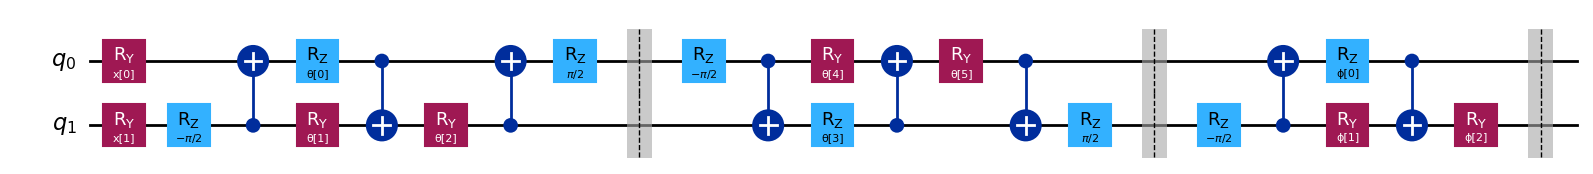

In [4]:
qc.draw('mpl')